<a href="https://colab.research.google.com/github/PnZheng/DeepLearning/blob/main/CNN/lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LeNet

在这里我们将对LeNet模型进行定义，初始化和训练，并利用训练好的模型来进行预测。

我们引入了matplotlib来展示训练时的图像, 并且手工设置了随机种子以确保实验的可重复性。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

torch.manual_seed(55)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 在这，我们定义好LeNet的结构框架

- 3 图像输入通道, 6 特征输出通道 和 5x5 的卷积核
- 6 图像输入通道, 16 特征输出通道 和 5x5 的卷积核
- 全连接层，其大小分别为 120, 84 and 10

## 网络在运行时候执行向前传递的一个默认函数（forward）

他的执行方向和框架依照下图进行。
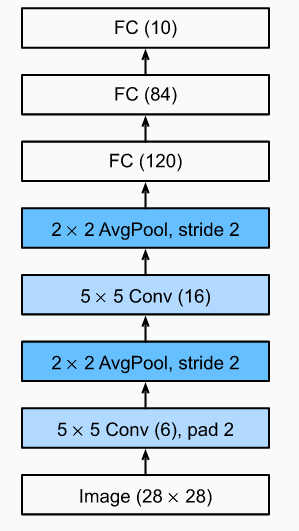


将空间和深度的数据平展到单一向量中去 -> x = x.view(-1, self.flattened_features(x))


## 此外，我们定义了flatteed_features函数来统计该模型中参数的总和。

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cn1 = nn.Conv2d(3, 6, 5)
        self.cn2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
 
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.cn2(x))
        x = F.max_pool2d(x, (2, 2))
        x = x.view(-1, self.flattened_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def flattened_features(self, x):
        size = x.size()[1:]  
        num_feats = 1
        for s in size:
            num_feats *= s
        return num_feats


lenet = LeNet()
lenet = lenet.to(device)
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 在这里我们将具体实现以下训练过程的函数

1. 首先需要对损失进行初始化 $loss_total = 0.0$。

2. 随后通过**enumerate**函数获取输入
    - 输入数组格式为：[inputs, labels]
    - ip代变着输入图像（input images）, ground_truth 表示输出的真实分类

3. 在每次运行时，需要将之前遗留下来的梯度进行清空：optim.zero_grad()

4. 随后，执行Lenet函数的前向传播和后向传播，以及参数优化步骤

5. 每训练完1000个小批量数据时候，就打印损失的数据

In [3]:
def train(net, trainloader, optim, epoch):
    loss_total = 0.0
    
    for i, data in enumerate(trainloader, 0):
        
        ip, ground_truth = data
        ip, ground_truth = ip.to(device), ground_truth.to(device)
        optim.zero_grad()
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step()
        loss_total += loss.item()
        
        if (i+1) % 1000 == 0:    
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_total / 200))
            loss_total = 0.0

## 我们将定义用于评估模型性能的测试函数：

通过统计函数得到的pred标签与真实的标签，之后利用公式：$accuracy = success / counter$，便可以简单得到准确率。

In [4]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            im, ground_truth = im.to(device), ground_truth.to(device)
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()

    print('LeNet accuracy on 10000 images from test dataset: %d %%' % (
        100 * success / counter))

## 在这里我们将使用CIFAR-10的数据集进行训练验证

- 首先需要定义好transform方便对输入数据进行预处理
- 以下包括随机的水平颠倒、随机对图像进行裁剪、以及将图像转化为Tensor数据和对数据的归一化
- 将像素进行归一化到0-1的时，可以将归一化的像素值的均值和方差设置为0.5 

若已经使用下载好了数据集，将download设置为false即可。 
相关数据集已放在目录下。

In [5]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# 加载数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=1)
# 测试机的数据预处理
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False, num_workers=2)

# ordering is important
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 这里定义一个图片展示的函数，以便更好的观察

在函数中首先，需要对图像数据进行逆标准化后，才能进行plt.imshow展示。

在训练集中进行图像才有
在表格中展示数据
打印标签


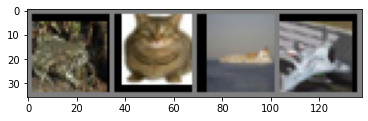

    frog  ||  cat  ||  ship  ||  plane


In [77]:
def imageshow(image):
    image = image/2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()

num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
print('    '+'  ||  '.join(classes[labels[j]] for j in range(num_images)))

# 定义优化器，学习率lr = 0.001
# 训练数据集。并且同时测试验证集的准确率


In [73]:
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

for epoch in range(50):  
    train(lenet, trainloader, optim, epoch)
    print()
    test(lenet, testloader)
    print()

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 6.744
[Epoch number : 1, Mini-batches:  2000] loss: 6.684
[Epoch number : 1, Mini-batches:  3000] loss: 6.613
[Epoch number : 1, Mini-batches:  4000] loss: 6.525
[Epoch number : 1, Mini-batches:  5000] loss: 6.643
[Epoch number : 1, Mini-batches:  6000] loss: 6.565

LeNet accuracy on 10000 images from test dataset: 56 %

[Epoch number : 2, Mini-batches:  1000] loss: 6.477
[Epoch number : 2, Mini-batches:  2000] loss: 6.436
[Epoch number : 2, Mini-batches:  3000] loss: 6.338
[Epoch number : 2, Mini-batches:  4000] loss: 6.270
[Epoch number : 2, Mini-batches:  5000] loss: 6.363
[Epoch number : 2, Mini-batches:  6000] loss: 6.349

LeNet accuracy on 10000 images from test dataset: 57 %

[Epoch number : 3, Mini-batches:  1000] loss: 6.194
[Epoch number : 3, Mini-batches:  2000] loss: 6.382
[Epoch number : 3, Mini-batches:  3000] loss: 6.131
[Epoch number : 3, Mini-batches:  4000] loss: 6.129
[Epoch number : 3, Mini-batches:  5000] loss: 6.117
[E

[Epoch number : 23, Mini-batches:  1000] loss: 5.353
[Epoch number : 23, Mini-batches:  2000] loss: 5.203
[Epoch number : 23, Mini-batches:  3000] loss: 5.151
[Epoch number : 23, Mini-batches:  4000] loss: 5.228
[Epoch number : 23, Mini-batches:  5000] loss: 5.218
[Epoch number : 23, Mini-batches:  6000] loss: 5.235

LeNet accuracy on 10000 images from test dataset: 66 %

[Epoch number : 24, Mini-batches:  1000] loss: 5.212
[Epoch number : 24, Mini-batches:  2000] loss: 5.095
[Epoch number : 24, Mini-batches:  3000] loss: 5.110
[Epoch number : 24, Mini-batches:  4000] loss: 5.194
[Epoch number : 24, Mini-batches:  5000] loss: 5.198
[Epoch number : 24, Mini-batches:  6000] loss: 5.188

LeNet accuracy on 10000 images from test dataset: 68 %

[Epoch number : 25, Mini-batches:  1000] loss: 5.141
[Epoch number : 25, Mini-batches:  2000] loss: 5.245
[Epoch number : 25, Mini-batches:  3000] loss: 5.135
[Epoch number : 25, Mini-batches:  4000] loss: 5.133
[Epoch number : 25, Mini-batches:  500


LeNet accuracy on 10000 images from test dataset: 67 %

[Epoch number : 45, Mini-batches:  1000] loss: 4.924
[Epoch number : 45, Mini-batches:  2000] loss: 5.073
[Epoch number : 45, Mini-batches:  3000] loss: 4.935
[Epoch number : 45, Mini-batches:  4000] loss: 4.953
[Epoch number : 45, Mini-batches:  5000] loss: 5.107
[Epoch number : 45, Mini-batches:  6000] loss: 4.978

LeNet accuracy on 10000 images from test dataset: 67 %

[Epoch number : 46, Mini-batches:  1000] loss: 4.910
[Epoch number : 46, Mini-batches:  2000] loss: 5.002
[Epoch number : 46, Mini-batches:  3000] loss: 5.092
[Epoch number : 46, Mini-batches:  4000] loss: 4.898
[Epoch number : 46, Mini-batches:  5000] loss: 4.881
[Epoch number : 46, Mini-batches:  6000] loss: 4.906

LeNet accuracy on 10000 images from test dataset: 66 %

[Epoch number : 47, Mini-batches:  1000] loss: 5.039
[Epoch number : 47, Mini-batches:  2000] loss: 4.931
[Epoch number : 47, Mini-batches:  3000] loss: 4.996
[Epoch number : 47, Mini-batches: 

## 保存训练好的模型参数数据

In [26]:
model_path = './cifar_model.pth'
torch.save(lenet.state_dict(), model_path)

In [29]:
images[:4].shape

torch.Size([4, 3, 32, 32])

 ## 训练完后，我们对模型进行一个图像预测
 - 首先加载验证数据
 - 展示图像和他真实的标签
 - 加载已经训练好的模型及参数
 - 模型对图像进行预测推断
 - 打印预测值

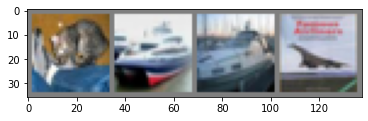

Label:         cat  ship  ship plane
Prediction:    cat  ship  ship plane


In [30]:
d_iter = iter(testloader)
im, ground_truth = d_iter.next()

imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

op = lenet_cached(im)

_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

## 统计该模型的预测准确率


In [31]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on 10000 images from test dataset: %d %%' % (
    100 * success / counter))

Model accuracy on 10000 images from test dataset: 67 %


# 统计每一个类别的精确度

In [32]:
class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(10000):
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1


for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (
        classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class plane : 76 %
Model accuracy for class   car : 82 %
Model accuracy for class  bird : 62 %
Model accuracy for class   cat : 56 %
Model accuracy for class  deer : 56 %
Model accuracy for class   dog : 40 %
Model accuracy for class  frog : 85 %
Model accuracy for class horse : 71 %
Model accuracy for class  ship : 70 %
Model accuracy for class truck : 74 %


# 练习
尝试构建一个基于 LeNet 的更复杂的网络，以提高其准确性，如：
- 调整卷积窗口大小。
- 调整输出通道的数量。
- 调整激活函数（如 ReLU）。
- 调整卷积层的数量。
- 调整全连接层的数量。
- 调整学习率和其他训练细节（例如，初始化和周期数）。